In [38]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from numpy import where
import pandas as pd
import re
import seaborn as sns

from nltk.tokenize import RegexpTokenizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

# Setup

In [39]:
df = pd.read_csv("/home/jupyter/fake_job_postings.csv",index_col='job_id')

Because we've identified the False Negative to be the errors with the highest cost and because we'd rather use a ROC_AUC score (as well as the ROC curve which has the benefit to help us fine tune the most efficient model), we've decided to swap the values in the 'fraudulent' column. This means the model will now predict if a job post is legitimate and it will allow us to minimise the False positive (when an offer is flagged as legit by the model but actually is of fraudulent nature):

In [40]:
df['fraudulent'].replace([0,1], [1,0], inplace=True)

## Addressing the missing information

We have decided to address the missing information in the different columns by replacing the lack of information by `NA`. Instead of using the 'Other' or 'Unspecified' values available in certain columns, this will allow us to quickly spot when the information was not provided:
01. title:               No missing data
02. location:            NA
03. department:          NA
04. salary_range:        NA
05. company_profile:     NA
06. description:         NA
07. requirements:        NA
08. benefits:            NA
09. telecommuting:       No missing data
10. has_company_logo:    No missing data
11. has_questions:       No missing data
12. employment_type:     NA
13. required_experience: NA
14. required_education:  NA
15. industry:            NA
16. function:            NA
17. fraudulent:          No missing data

In [41]:
for column in df.columns:
    df[column].fillna('NA', inplace=True)

 Some job offers have contact details or external url. Could this be linked to fraudulent activity? Could this improve our model's performance?

In [42]:
# turn into a function: use dict (columnName:textToSearch, list(dictinput.keys())[0]:list(dictinput.values())[0])
df = df.assign(hasEMAIL=0, hasPHONE=0, hasURL=0)
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        if df[column][i].find('#URL_')!=-1:
            df['hasURL'][i] = 1
        elif df[column][i].find('#PHONE_')!=-1:
            df['hasPHONE'][i] = 1
        elif df[column][i].find('#EMAIL_')!=-1:
            df['hasEMAIL'][i] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Some job offers have been written in other alphabets, such as russian or greek. But because those job offers were flagged as legitimate and because we wouldn't be able to understand those offers fully (not speaking the language), we are going to remove them from our dataset:

In [43]:
index_non_latin = []
for column in df.columns[4:8]:
        index_non_latin.append(df[df[column].str.find('α')!=-1].index)
        index_non_latin.append(df[df[column].str.find('и')!=-1].index)
        index_non_latin.append(df[df[column].str.find('แ')!=-1].index)
        index_non_latin.append(df[df[column].str.find('υ')!=-1].index)
        index_non_latin.append(df[df[column].str.find('ο')!=-1].index)
        index_non_latin.append(df[df[column].str.find('ι')!=-1].index)
        index_non_latin.append(df[df[column].str.find('ε')!=-1].index)
        index_non_latin.append(df[df[column].str.find('μ')!=-1].index)

In [44]:
for i in range(1,len(index_non_latin)):
    index_non_latin[0] = index_non_latin[0].append(index_non_latin[i])

In [45]:
index_non_latin = sorted(set(list(index_non_latin[0])))

In [46]:
df[df.index.isin(index_non_latin)]['fraudulent'].value_counts()

1    90
Name: fraudulent, dtype: int64

In [47]:
df = df[df.index.isin(index_non_latin)==False]
df.reset_index(inplace=True)
len(df)

17790

## Text cleaning and pre-processing

In [48]:
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        df[column][i] = re.sub(r'([A-Z][a-z])', r' \1', df[column][i])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Let's see if any clear pattern can already be identified:

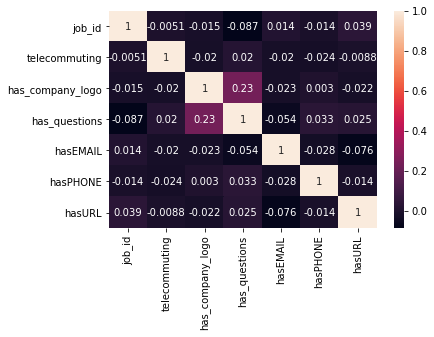

In [49]:
sns.heatmap(df.drop(columns=['fraudulent']).corr(), annot=True);

No multicollinearity issues with those binary variables

# Information loss

Some information is too complex to deal with (e.g. `'title'` has 11,231 unique values over the 17,790 job offers in this dataset), or has too much missing values (`'salary_range'` has 14,925 missing values over the 17,790 in this dataset), either ways they would marginally improve the results of our analysis so we are going to remove those columns from our dataset.

In [56]:
df.drop(columns=['job_id','title', 'location', 'department', 'salary_range'], inplace=True)

# Train Test Split

In [59]:
labels = df['fraudulent']
features = df.drop(columns=['fraudulent'])

In [60]:
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                    labels,
                                                    random_state=666)

# Initialising K-Folds
kfold = KFold(n_splits=5,
              random_state=666,
              shuffle=True
             )

# Dataset formatting

## Numerise the categorical data

In [75]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [76]:
cat_features = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
features_train_cat = features_train.loc[:, cat_features]
features_test_cat = features_test.loc[:, cat_features]

In [79]:
features_train_ohe = ohe.fit_transform(features_train_cat)
features_test_ohe = ohe.transform(features_test_cat)

In [ ]:
cat_train_df = pd.DataFrame(features_train_ohe, columns=ohe.get_feature_names(input_features=cat_features))
cat_test_df = pd.DataFrame(features_test_ohe, columns=ohe.get_feature_names(input_features=cat_features))

## TF-IDF computation on the text data

In [91]:
vect_comp = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english')
vect_desc = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english')
vect_req = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english')
vect_ben = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english')

In [92]:
text_features = ['company_profile', 'description', 'requirements', 'benefits']
features_train_text = features_train.loc[:, text_features]
features_test_text = features_test.loc[:, text_features]

In [93]:
# train
features_train_vectorized_c = vect_comp.fit_transform(features_train_text['company_profile'])
features_train_vectorized_d = vect_desc.fit_transform(features_train_text['description'])
features_train_vectorized_r = vect_req.fit_transform(features_train_text['requirements'])
features_train_vectorized_b = vect_ben.fit_transform(features_train_text['benefits'])
# test
features_test_vectorized_c = vect_comp.transform(features_test_text['company_profile'])
features_test_vectorized_d = vect_desc.transform(features_test_text['description'])
features_test_vectorized_r = vect_req.transform(features_test_text['requirements'])
features_test_vectorized_b = vect_ben.transform(features_test_text['benefits'])

In [94]:
ftrainvc_df = pd.DataFrame(features_train_vectorized_c.todense(), columns=vect_comp.get_feature_names())
ftrainvd_df = pd.DataFrame(features_train_vectorized_d.todense(), columns=vect_desc.get_feature_names())
ftrainvr_df = pd.DataFrame(features_train_vectorized_r.todense(), columns=vect_req.get_feature_names())
ftrainvb_df = pd.DataFrame(features_train_vectorized_b.todense(), columns=vect_ben.get_feature_names())
text_train_df = pd.concat([ftrainvc_df, ftrainvd_df, ftrainvr_df, ftrainvb_df], axis=1)
ftestvc_df = pd.DataFrame(features_test_vectorized_c.todense(), columns=vect_comp.get_feature_names())
ftestvd_df = pd.DataFrame(features_test_vectorized_d.todense(), columns=vect_desc.get_feature_names())
ftestvr_df = pd.DataFrame(features_test_vectorized_r.todense(), columns=vect_req.get_feature_names())
ftestvb_df = pd.DataFrame(features_test_vectorized_b.todense(), columns=vect_ben.get_feature_names())
text_test_df = pd.concat([ftestvc_df, ftestvd_df, ftestvr_df, ftestvb_df], axis=1)

In [97]:
text_train_df.shape[0]*text_train_df.shape[1]

1067893680

## Binary data

# Addressing the class imbalance

As class imbalance will only matter during the training step, SMOTE will only be applied to to train dataset.

In [ ]:
# SMOTE doesn't work on text, it needs to be changed to TF-IDF
sm = SMOTE(random_state=666, n_jobs=4)

In [ ]:
X, y = sm.fit_resample(, labels_train)

## Shape check

In [ ]:
print('X', X.shape)
print('y', y.shape)
print('labels_train', labels_train.value_counts())
print('y.value_counts', y.value_counts())

# Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB()

In [ ]:
gnb.fit(X.todense(), y)

In [ ]:
labels_train_pred = gnb.predict_proba(X.todense())

In [ ]:
labels_train_pred[:,1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y, labels_train_pred[:,1])
print('AUC train dataset: {}'.format(auc(fpr, tpr)))

# Multinomial Naive Bayes

In [ ]:
mnb = MultinomialNB()

In [ ]:
mnb.fit(X.todense(), y)

In [ ]:
labels_train_pred = mnb.predict_proba(X.todense())

In [ ]:
fpr, tpr, thresholds = roc_curve(y, labels_train_pred[:,1])
print('AUC train dataset: {}'.format(auc(fpr, tpr)))

# Random Forest

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=666)

In [ ]:
rfc.fit(X.todense(), y)

In [ ]:
rfc.get_params

In [ ]:
labels_train_pred = rfc.predict(X.todense())

In [ ]:
fpr, tpr, thresholds = roc_curve(y, labels_train_pred)
print('AUC train dataset: {}'.format(auc(fpr, tpr)))

# Finialising the selected model

## Confusion matrix

In [ ]:
y_hat_test = rfc.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_hat_test)

# Create the basic matrix
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
class_names = set(y) # Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

# Add a legend
plt.colorbar()
plt.show()

In [ ]:
cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
def conf_matrix(self,y_test, y_hat_test):
        for ind, label in enumerate(y_test):
            pred = y_hat_test[ind]
            if label == 1: 
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
            self.cm_values = cm
        return cm

In [ ]:
conf_matrix(rfc,y_test,y_hat_test)

## Receiver Operating Characteristic

In [ ]:
def buildROC(target_train, train_preds, target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    fpr1, tpr1, threshold = metrics.roc_curve(target_train, train_preds)
    roc_auc1 = metrics.auc(fpr1, tpr1)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr1, tpr1, 'b', label = 'Train AUC = %0.2f' % roc_auc1)
    plt.plot(fpr, tpr, 'b', label = 'Validation AUC = %0.2f' % roc_auc, color = 'g')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

In [ ]:
training_preds = .predict(X_train)
test_preds = .predict(X_test)

training_roc_auc = roc_auc_score(y_train, training_preds)
test_roc_auc = roc_auc_score(y_test, test_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(test_roc_auc * 100))

### ROC plot

In [ ]:
# Plotting the ROC curve
buildROC(y_train, training_preds, y_validate, validate_preds)

In [ ]:
def annot(fpr,tpr,thr):
    k=0
    for i,j in zip(fpr,tpr):
        if k %75 == 0:
            plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
        k+=1

In [ ]:
for data in [[y_train, y_train_score[:,1]],[y_validate, y_validate_score[:,1]],[y_test, y_test_score[:,1]]]:
    fpr, tpr, threshold = roc_curve(data[0], data[1])
    plt.plot(fpr, tpr)
annot(fpr, tpr, threshold)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.ylabel('TPR (power)')
plt.xlabel('FPR (alpha)')
plt.legend(['train','validation','test'])
plt.show()

### Threshold selection

In [ ]:
threshold_chosen = 0
difference = 0
for i in range(len(thresholds)):
    temp = tpr[i]-fpr[i]
    if temp>difference:
        difference=temp
        threshold_chosen=thresholds[i]
threshold_chosen = round(threshold_chosen,2)
print('Best Threshold: ',threshold_chosen)

## Cost Function

In [ ]:
#The cost function terms are wrong, double check those!

# Focusing on a stat that improves your game
cTP = 100
# Not focusing on a stat that doesn't improve your game
cTN = 1
# Focusing on a stat that doesn't improve your game
cFP = 100
# Not focusing on a stat that improves your game
cFN = 20

prevalence = (cm['TP']+cm['FN']) / (cm['TP']+cm['FP']+cm['TN']+cm['FN'])

# Metz coefficient
_m = ((1-prevalence)/prevalence) * ((cFP-cTN) / (cFN-cTP))

# Using the Zweig & Campbell equation:
function_m = cm['TP'] -_m*cm['FP']
function_m